In [1]:
import pandas as pd
import seaborn as sns

In [2]:
import xgboost

In [3]:
import pickle

In [4]:
import util

In [5]:
import matplotlib.pyplot as plt

In [6]:
import numpy as np

# 1. Get Score from Model

In [7]:
query1 = """
WITH 
T1 AS (
    SELECT * FROM CINS_REACTIVATED_SCORE_01102023),
T2 AS (
    SELECT * FROM DW_ANALYTICS.DW_CUST_PRODUCT_LOC_FCT),
T3 AS (
    SELECT DISTINCT T1.*
    FROM T1
    INNER JOIN T2 ON T1.CUSTOMER_CDE = T2.CUSTOMER_CDE
    WHERE T2.PROCESS_DT = TO_DATE('30-09-23','DD-MM-YY')
    )
SELECT * FROM T3
"""

In [8]:
df = util.download_or_reload('SCORE_10', query1)

In [9]:
df['CUSTOMER_CDE'].nunique()

16183759

In [10]:
df3 = df

# 2. Get label

In [11]:
query2 = """WITH
T0 AS (
    SELECT * FROM CINS_TMP_CUSTOMER_01102023
),
T1 AS (
    SELECT * FROM DW_ANALYTICS.DW_CUST_PRODUCT_LOC_FCT
    WHERE PROCESS_DT = TO_DATE('30-09-2023', 'DD-MM-YY')
    OR PROCESS_DT = TO_DATE('31-08-2023', 'DD-MM-YY')
),
T2 AS (
    SELECT T0.CUSTOMER_CDE, T1.PROCESS_DT AS RPT_DT,
        MAX(CASE
            WHEN T1.CUST_STATUS = 'HOAT DONG' THEN 2
            WHEN T1.CUST_STATUS = 'NGU DONG' THEN 1
            WHEN T1.CUST_STATUS = 'DONG BANG' THEN 0
        END) AS CUST_STT
    FROM T0 
    INNER JOIN T1 ON T0.CUSTOMER_CDE = T1.CUSTOMER_CDE
    GROUP BY T0.CUSTOMER_CDE, PROCESS_DT
),
T3 AS (
    SELECT CUSTOMER_CDE, 
    RPT_DT, LAG(RPT_DT) OVER (PARTITION BY CUSTOMER_CDE ORDER BY RPT_DT) AS RPT_DT_LAG, 
    CUST_STT, LAG(CUST_STT) OVER (PARTITION BY CUSTOMER_CDE ORDER BY RPT_DT) AS CUST_STT_LAG
    FROM T2
),
T4 AS (
    SELECT CUSTOMER_CDE, 
    RPT_DT, RPT_DT_LAG,
    CUST_STT, CUST_STT_LAG, CUST_STT - CUST_STT_LAG AS CUST_STT_CHG
    FROM T3 
    WHERE RPT_DT = TO_DATE('30-09-2023', 'DD-MM-YY')
),
T5 AS (
    SELECT CUSTOMER_CDE, RPT_DT, RPT_DT_LAG, CUST_STT, CUST_STT_LAG, CUST_STT_CHG,
    CASE 
        WHEN CUST_STT = 2 AND CUST_STT_CHG >= 1 THEN 1
        WHEN CUST_STT <= 1 AND CUST_STT_LAG <= 1 THEN 0
    END AS REACTIVATED
    FROM T4
),
T6 AS (
    SELECT CUSTOMER_CDE,
    'REACTIVATED' AS FTR_NM,
    REACTIVATED AS FTR_VAL,
    TO_DATE('01-10-2023', 'DD-MM-YY') AS RPT_DT,
    CURRENT_TIMESTAMP ADD_TSTP
    FROM T5
    WHERE REACTIVATED IS NOT NULL
)
SELECT * FROM T6"""

In [12]:
gt = util.download_or_reload('LABEL_10', query2)

In [13]:
len(gt)

7649958

In [14]:
gt['FTR_VAL'].value_counts()

0    7607380
1      42578
Name: FTR_VAL, dtype: int64

In [15]:
df4 = df3.merge(gt[['CUSTOMER_CDE', 'FTR_VAL']], how='left', left_on='CUSTOMER_CDE', right_on='CUSTOMER_CDE')
df4 = df4.rename(columns={'FTR_VAL': 'REACTIVATED'})

In [16]:
df4 = df4.dropna()

# Plot histogram

In [17]:
import seaborn as sns

In [18]:
# sns.kdeplot(df4, hue='REACTIVATED', x='SCORE', common_norm=False)

In [19]:
from sklearn import metrics

In [20]:
y_true = df4['REACTIVATED'].values
y_pred = df4['SCORE'].values

In [21]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
metrics.auc(fpr, tpr)

0.975412450623284

## Plot AUC

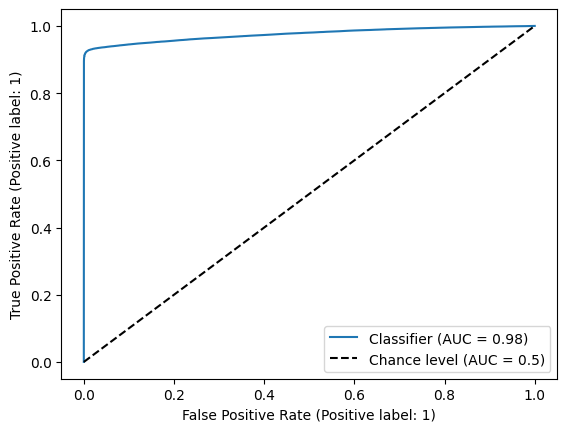

In [22]:
display = metrics.RocCurveDisplay.from_predictions(y_true, y_pred, plot_chance_level=True)

In [23]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7649957 entries, 82 to 16183758
Data columns (total 3 columns):
 #   Column        Dtype  
---  ------        -----  
 0   CUSTOMER_CDE  object 
 1   SCORE         float64
 2   REACTIVATED   float64
dtypes: float64(2), object(1)
memory usage: 233.5+ MB


# CAP & Gini & Lift

In [24]:
df = df4.copy()
df = df.rename(columns={'SCORE': 'PROBA_REACTIVE', 'REACTIVATED': 'LABEL'})
df['PROBA_NOREACTIVE'] = 1 - df['PROBA_REACTIVE']
df['LABEL'] = df['LABEL'].apply(lambda x: 'REACTIVATED' if x == 1 else 'NOT_REACTIVATED')

In [25]:
df = df.sort_values(by='PROBA_NOREACTIVE')

In [26]:
# df['bin'] = pd.qcut(df['PROBA_NOREACTIVE'], q=100, labels=False)
num_bins = 1000
bucket_size = len(df) // num_bins
buckets = [i for i in range(num_bins) for j in range(bucket_size)] + [num_bins-1] * (len(df) % num_bins)
df['bin'] = buckets

In [27]:
df = df.groupby('bin')['LABEL'].value_counts().to_frame(name='count').reset_index().pivot(index='bin', columns='LABEL', values='count')
df['NOT_REACTIVATED'] = df['NOT_REACTIVATED'].fillna(0)

In [28]:
df['total_lead'] = df['REACTIVATED'] + df['NOT_REACTIVATED']

In [29]:
total_reactivated = df['REACTIVATED'].sum()
total_leads = df['total_lead'].sum()
total_leads, total_reactivated

(6693832.0, 42578.0)

In [30]:
df['perc_REACTIVATED'] = df['REACTIVATED'] / total_reactivated * 100
df['cumsum_REACTIVATED'] = df['REACTIVATED'].cumsum()
df['perc_cumsum_REACTIVATED'] = df['cumsum_REACTIVATED'] / total_reactivated * 100
df['lift'] = df['perc_cumsum_REACTIVATED'] / (df['total_lead'].cumsum() / total_leads)  / 100

In [31]:
df = df[['total_lead', 'REACTIVATED', 'cumsum_REACTIVATED', 'perc_REACTIVATED', 'perc_cumsum_REACTIVATED', 'lift']]

In [32]:
df = df.reset_index()

In [33]:
df

LABEL,bin,total_lead,REACTIVATED,cumsum_REACTIVATED,perc_REACTIVATED,perc_cumsum_REACTIVATED,lift
0,0,7649.0,7649.0,7649.0,17.964677,17.964677,157.213397
1,1,7649.0,7649.0,15298.0,17.964677,35.929353,157.213397
2,2,7649.0,7649.0,22947.0,17.964677,53.894030,157.213397
3,3,7649.0,7649.0,30596.0,17.964677,71.858706,157.213397
4,4,7649.0,6882.0,37478.0,16.163277,88.021983,154.060496
...,...,...,...,...,...,...,...
995,995,7649.0,4.0,42573.0,0.009395,99.988257,1.004618
996,996,7649.0,1.0,42574.0,0.002349,99.990605,1.003490
997,997,7649.0,2.0,42576.0,0.004697,99.995303,1.002387
998,998,7649.0,1.0,42577.0,0.002349,99.997651,1.001264


In [34]:
total_react = df['REACTIVATED'].sum()
for i in [10000, 50000, 100000, 300000]:
    df1 = df[:int(np.ceil(i/df.iloc[0]['total_lead']))]
    max_act = df1['total_lead'].sum() if df1['total_lead'].sum() < total_react else total_react
    acc_pct = df1['REACTIVATED'].sum() / max_act
    print(acc_pct)

1.0
0.914533327070318
0.9262295081967213
0.9352247639626098


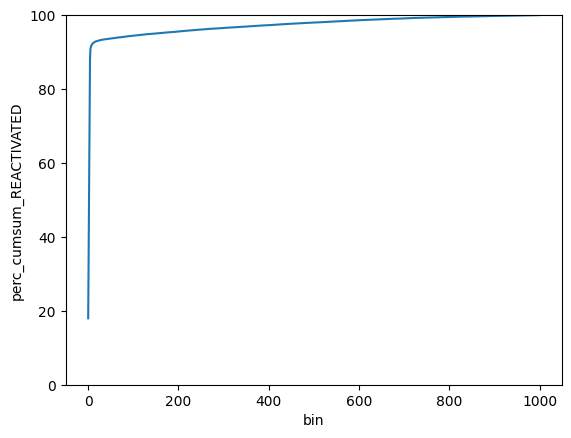

In [35]:
ax = sns.lineplot(df[['bin', 'perc_cumsum_REACTIVATED']], x='bin', y='perc_cumsum_REACTIVATED')
ax.set_ylim(0, 100)
plt.show()